In [45]:
# import libraries
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import plotly.plotly as py
#import plotly.offline as pyoff
#import plotly.graph_objs as go

#inititate Plotly
#pyoff.init_notebook_mode()


In [2]:
#load our data from CSV
tx_data = pd.read_csv('E:\SP Jain\python files_boot camp project\DataCosuppychain dataset\data.csv')
tx_data.head()

#convert the string date field to datetime
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

tx_uk = tx_data

In [3]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

tx_user.head()


,CustomerID,Recency
0,20755,304
1,19492,322
2,19491,322
3,19490,322
4,19489,322


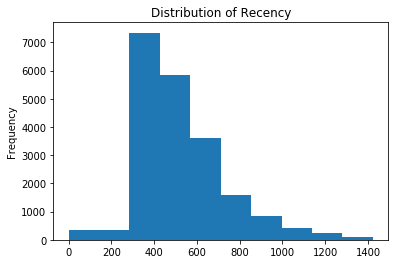

In [8]:
#plot a recency histogram
tx_user['Recency'].plot.hist(title='Distribution of Recency')
plt.show()

In [9]:
tx_user['Recency'].describe()

count    20652.000000
mean       523.394974
std        208.868146
min          0.000000
25%        381.000000
50%        475.500000
75%        626.000000
max       1423.000000
Name: Recency, dtype: float64

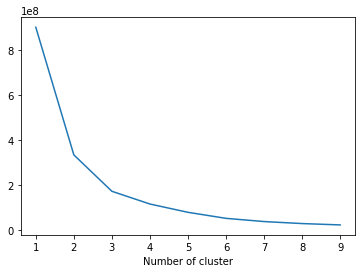

In [10]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [12]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
tx_user

,CustomerID,Recency,RecencyCluster
0,20755,304,3
1,19492,322,3
2,19491,322,3
3,19490,322,3
4,19489,322,3
...,...,...,...
20647,9929,1106,0
20648,8213,1282,0
20649,3657,1164,0
20650,6647,1258,0


In [13]:
#Frequency:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

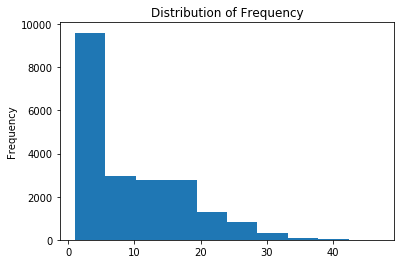

In [15]:
tx_user['Frequency'].plot.hist(title='Distribution of Frequency')
plt.show()

In [16]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,9608.0,1.351894,1.016633,1.0,1.0,1.0,1.0,5.0
1,5047.0,9.743412,2.204862,6.0,8.0,10.0,12.0,13.0
2,4235.0,17.000472,2.228132,14.0,15.0,17.0,19.0,21.0
3,1762.0,26.309875,4.186917,22.0,23.0,25.0,28.0,47.0


In [17]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')


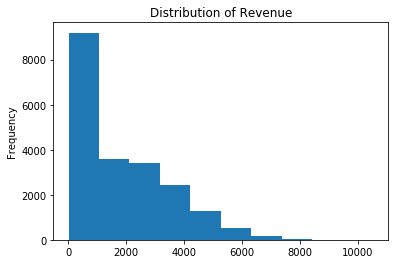

In [18]:
tx_user['Revenue'].plot.hist(title='Distribution of Revenue')
plt.show()

In [19]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,9249.0,297.997022,250.589159,11.290000,84.400002,252.880005,452.040008,1084.810015
1,5363.0,1873.200443,432.584698,1089.759994,1500.000000,1859.800026,2244.715033,2635.670054
2,4274.0,3398.387888,485.932220,2637.780079,2979.580050,3349.555050,3786.905061,4375.410069
3,1766.0,5355.536077,882.588159,4377.480076,4676.727612,5123.885109,5779.307622,10524.170139


In [20]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,1125.035047,3.147196,587.123936
1,742.186117,2.507042,465.119435
2,667.744671,3.644898,677.898040
3,416.223313,2.795817,585.967829
4,541.758902,9.084941,1990.059924
5,582.115426,14.208511,2831.069211
6,522.819039,17.268143,3456.011788
7,493.698492,20.420436,4116.837907
8,490.439362,26.408511,5391.426429


# To keep things simple, better we name these scores:
0 to 2: Low Value
3 to 4: Mid Value
5+: High Value

In [21]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [22]:
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,20755,304,3,1,0,327.750000,0,3,Mid-Value
1,19492,322,3,1,0,327.750000,0,3,Mid-Value
2,19491,322,3,1,0,327.750000,0,3,Mid-Value
3,19490,322,3,1,0,327.750000,0,3,Mid-Value
4,19489,322,3,1,0,327.750000,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...
20647,1505,916,0,23,3,4914.320093,3,6,High-Value
20648,9746,1205,0,23,3,4436.590119,3,6,High-Value
20649,7143,919,0,27,3,4869.380102,3,6,High-Value
20650,3197,1102,0,22,3,4571.520075,3,6,High-Value


In [23]:
tx_user.to_csv('RFM.csv')

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

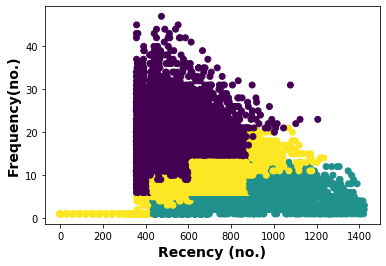

In [36]:
plt.scatter(x=tx_user['Recency'],
            y=tx_user['Frequency'],
            c=tx_user.Segment.astype('category').cat.codes)
plt.xlabel("Recency (no.)",
            fontweight ='bold',
            size=14)
plt.ylabel("Frequency(no.)",
           fontweight ='bold',
           size=14)
plt.savefig("Coloring_Scatterplot_with_Variable_matplotlib.png",
                    format='png',dpi=300)

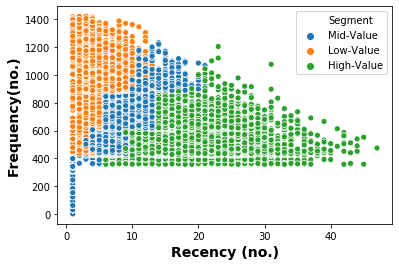

In [40]:
sns.scatterplot(x="Frequency", y="Recency", data=tx_user, hue="Segment")
plt.xlabel("Recency (no.)",
            fontweight ='bold',
            size=14)
plt.ylabel("Frequency(no.)",
           fontweight ='bold',
           size=14)
plt.savefig("Scatterplot_with_Variable_matplotlib.png",
                    format='png',dpi=300)